# **\[CGSP\]** Chap 8.3: Discrete Fourier Transform

JiyunLim  
2023-07-17

In [10]:
using LinearAlgebra, FFTW

# Discrete Fourier Transform

> Djuric and Richard (2018) 의 Chap. 8.3 의 내용중 일부를 요약함.

## Cyclic shfit operator ${\bf B}$

The matrix ${\bf B}$ representing the periodic shift is

In [1]:
B= [0 0 0 0 1
    1 0 0 0 0 
    0 1 0 0 0
    0 0 1 0 0
    0 0 0 1 0]

This matrix is the cyclic shift.

*note*: ${\bf B}$ is orthogonal matrix. (직교행렬: 전치행렬이 역행렬인
행렬 $\bf{A}\bf{A}'=\bf{A}'\bf{A}=\bf{I}$)

`-` periodic shift

${\bf A} = \begin{bmatrix} 0 & 0 & 0& \cdots & 0 & 1 \\ 1 & 0 & 0& \cdots & 0 & 0 \\ 0 & 1 & 0& \cdots & 0 & 0\\ \vdots & \vdots & \ddots & \ddots & \ddots & 0 \\ 0 & 0 & \cdots & 1 & 0 & 0 \\ 0 & 0 & \cdots & 0 & 1 & 0\end{bmatrix} \tag{8.4}$

`-` cyclic shift

$$\begin{align*}{\bf s}_{out} &= \begin{bmatrix} 0 & 0 & 0& \cdots & 0 & 1 \\ 1 & 0 & 0& \cdots & 0 & 0 \\ 0 & 1 & 0& \cdots & 0 & 0\\ \vdots & \vdots & \ddots & \ddots & \ddots & 0 \\ 0 & 0 & \cdots & 1 & 0 & 0 \\ 0 & 0 & \cdots & 0 & 1 & 0\end{bmatrix}{\bf s}_{in} \\ &= \begin{bmatrix} 0 & 0 & 0& \cdots & 0 & 1 \\ 1 & 0 & 0& \cdots & 0 & 0 \\ 0 & 1 & 0& \cdots & 0 & 0\\ \vdots & \vdots & \ddots & \ddots & \ddots & 0 \\ 0 & 0 & \cdots & 1 & 0 & 0 \\ 0 & 0 & \cdots & 0 & 1 & 0\end{bmatrix} \begin{bmatrix} s_0 \\ s_1 \\ \vdots \\ s_{N-1}\end{bmatrix} \\ &=\begin{bmatrix} s_{N-1} \\ s_0 \\ \vdots \\ s_{N-2} \end{bmatrix}
\end{align*}$$

-   여기서 ${\bf s}_{out}$은 신호 ${\bf s}_{in}$의 딜레이된 버전.

### `#` 예제

ref: [Cyclic shift의 개념](https://en.wikipedia.org/wiki/Circular_shift)

a circular shift is the operation of rearranging the entries in a tuple,
either by moving the final entry to the first position, while shifting
all other entries to the next position, or by performing the inverse
operation. A circular shift is a special kind of cyclic permutation,
which in turn is a special kind of permutation.

위를 요약하자면 조합론에서 순환이동이란 튜플의 항목을 재정렬하는
작업이다. 마지막 element를 첫번째 위치로 이동하고 다른 모든 element들은
다음 위치로 이동하는 것.

예를들어 (a, b, c, d)에 cyclic shift를 반복적으로 적용하면 다음과 같다.

-   `0` $(a, b, c, d)$ \# before cyclic shift (origin)
-   `1` $(d, a, b, c)$ \# 1step
-   `2` $(c, d, a, b)$ \# 2step
-   `3` $(b, c, d, a)$ \# 3step
-   `4` $(a, b, c, d)$ \# 4step –\> origin

*cyclic shift를 4번 반복하니까 원래 변환 전 원래 튜플로 돌아왔다.*

In [2]:
B # 1 cyclic shift

In [3]:
B'B # B는 orthogonal matrix니까 B'B = I일 것.

(ex1) Define ${\bf s}$ as

In [4]:
s = [1,2,3,4,5] ## origin
s

Observe that

In [5]:
B*s

결과: $[1,2,3,4,5] \to [5,1,2,3,4]$

-   맨 뒤에 5가 앞으로 나오고 나머지 값들은 한칸씩 뒤로 밀렸다.

`-` $\bf{B}^2$ 에 $s$를 곱하면?

In [6]:
B^2*s

결과: $[1,2,3,4,5] \to [5,1,2,3,4] \to [4,5,1,2,3]$

`-` $\bf{B}^3$ 에 $s$를 곱하면?

In [7]:
B^3*s

`-` $\bf{B}^5$에 $s$를 곱하면?

예상대로라면 원래 $s$인 $[1,2,3,4,5]$로 돌아올 것 같다.

In [8]:
B^5*s

Thus we can interprete the matrix ${\bf B}$ as cyclic shift operator
such that

$$
{\bf B}s_n =s_{n-1}
$$

for $n=1,\dots, N-1$ and ${\bf B}s_0 =s_N$.

*note:* ${\bf B}$는 시계열에서 다루는 backshift operator 와 비슷함.

## DFT

> ${\bf B}$의 고유벡터들은 푸리에 행렬의 col-vector들이었다.

The matrix ${\bf B}$ can be expressed as

${\bf B}={\bf DFT}^\ast \cdot {\bf \Lambda} \cdot {\bf DFT}$

where ${\bf DFT}$ is unitary and symmetric matrix and $\bf \Lambda$ is
diagonal matrix.

-   유니터리 행렬은 켤레 전치가 역행렬과 같은 복소수 정사각 행렬이다.

`-` ${\bf B}$의 고윳값과 고유벡터

In [19]:
B*[1,2,3,4,5]

$N=5$ 일 때, 방정식 ${\bf B}{\bf x} = \lambda {\bf x}$는 아래와 같은
5개의 고윳값과 고유벡터를 가진다.

${\bf B}{\bf x} = \begin{bmatrix} 0 & 0 & 0 & 0 & 1 \\  1 & 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 & 0\end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \\ x_3  \\ x_4 \\ x_5\end{bmatrix}=\begin{bmatrix} x_5 \\ x_1 \\ x_2  \\ x_3 \\ x_4\end{bmatrix}=\lambda \begin{bmatrix} x_1 \\ x_2 \\ x_3  \\ x_4 \\ x_5\end{bmatrix}$
에서
$\begin{pmatrix} x_5 = \lambda x_1\\ x_1 = \lambda x_2 \\ x_2 = \lambda x_3 \\ x_3= \lambda x_4 \\ x_4 = \lambda x_5\end{pmatrix}$

In [11]:
λ, Ψ = eigen(B)

In [20]:
Diagonal(λ)

In [21]:
B ≈ Ψ * Diagonal(λ) * Ψ'

Define ${\boldsymbol \Psi}^\ast={\bf DFT}$.

In [22]:
DFT = Ψ'

Note that the eigenvalues are not ordered in julia.

In [25]:
λ

In [488]:
λ[5], exp(-im* 2π/5 * 0)

In [34]:
abs(λ[3]) >  abs(λ[4])

In [489]:
λ[3], exp(-im* 2π/5 * 1)

In [490]:
λ[1], exp(-im* 2π/5 * 2)

In [491]:
λ[2], exp(-im* 2π/5 * 3)

## Spectral components and Frequencies

We remark:

**(1) Spectral components**: For $k = 0,1,2,\dots, N-1$, the $k$-th
column of ${\bf DFT}^\ast$ is defined by

$$\Psi_k:=\frac{1}{\sqrt{N}}\begin{bmatrix} 1 \\ e^{j\frac{2\pi}{N}k} \\ e^{j\frac{2\pi}{N}2k} \\ e^{j\frac{2\pi}{N}3k} \\  \dots \\ e^{j\frac{2\pi}{N}(N-1)k} \end{bmatrix}.\quad k=0,1,\dots,N-1$$

Note that $\Psi_k$ can be also interpreted as $\ell$-th eigenvector of
${\bf A}$ correspoding $\lambda_\ell = e^{-j\frac{2\pi}{N}k}$. Those
eigenvectors

$$\big\{{\bf 1},\Psi_1,\Psi_2, \dots, \Psi_{N-1}\big\}$$

form a complete orthonomal basis of $\mathbb{C}^N$. These vectors are
called spectral components.

**(2) Frequencies:** The diagonal entries of ${\bf \Lambda}$ are the
eigenvalues of the time shift ${\bf B}$. In Physics and in operator
theory, these eigenvalues are the frequencies of the signal. In DSP it
is more common to call frequencies

$$\Omega_k=\frac{-1}{2\pi j}\ln\lambda_k=\frac{-1}{2\pi j}\ln e^{-j \frac{2\pi}{N}k}=\frac{k}{N}, \quad k=0,1,2,\dots,N-1.$$

------------------------------------------------------------------------

The $N$ (time) frequencies $\Omega_k$ are all distinct, positive,
equally spaced, and increasing from $0$ to $\frac{N-1}{N}$. The spectral
components are the complex exponential sinusiodal functions. For
example, corresponding to the zero frequency is the DC spectral
component (a vector whose entries are constant and all equal to
$\frac{1}{\sqrt{N}}$).

# 내 마음대로 Summary

## DFT

일반적으로 우리가 알고있는 DFT[1]는 아래와 같다. (이 그림은
[위키피디아](https://en.wikipedia.org/wiki/Discrete_Fourier_transform)에서
캡쳐한 것이다)

<figure class="margin-caption">
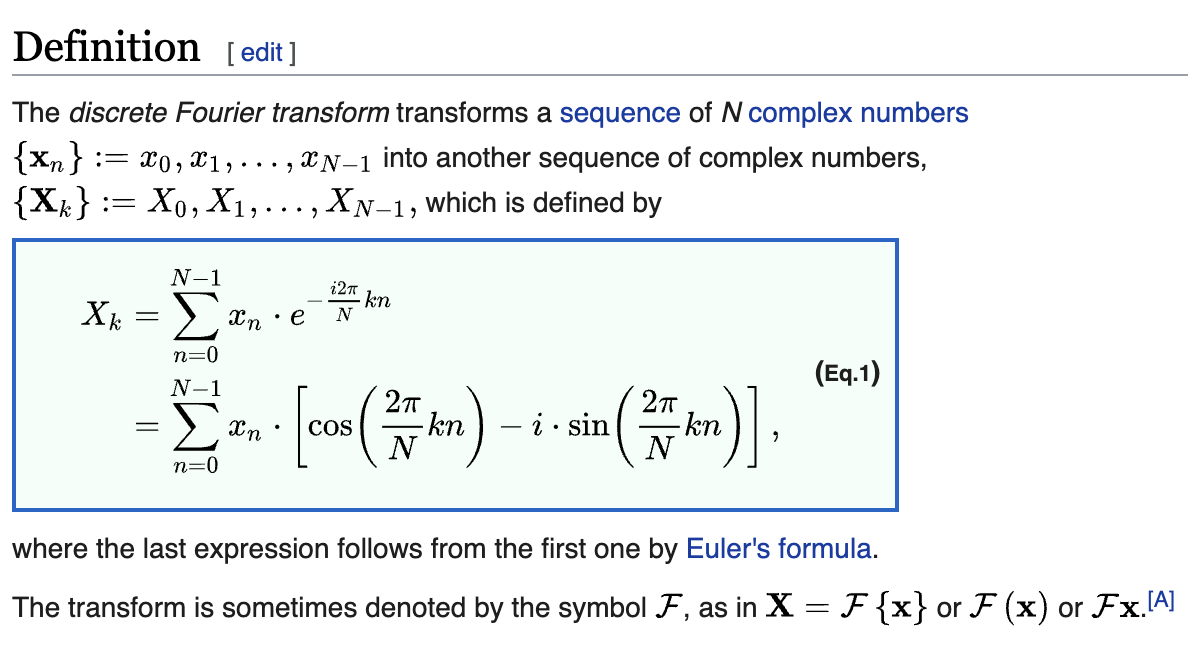
<figcaption aria-hidden="true">그림1: 위키에서 긁어온 DFT의
정의</figcaption>
</figure>

즉 DFT는 임의의 신호 $\{{\bf x}_n\}:=x_0,x_1,\dots,x_{N-1}$를 적당한
규칙[2]에 따라서 $\{{\bf X}_k\}:=X_0,X_1,\dots,X_{N-1}$로 바꾸는 변환을
이라고 이해할 수 있다. 이때 사용되는 적당한 규칙은 구체적으로 아래의
수식을 의미한다.

$$X_k = \sum_{n=0}^{N-1}x_n\cdot e^{-i\frac{2\pi}{N}kn}$$

그런데 매트릭스를 활용하면 위의 수식을 아래와 같이 표현할 수 있다.

$$\begin{bmatrix} X_1 \\ X_2 \\ X_3 \\ \dots \\ X_{N-1} \end{bmatrix} 
=\begin{bmatrix} 
1 & 1 & 1 & \dots & 1 \\
1 & e^{-i \frac{2\pi}{N}\cdot 1} & e^{-i \frac{2\pi}{N}\cdot 2} & \dots & e^{-i \frac{2\pi}{N}\cdot (N-1)}\\
1 & e^{-i \frac{2\pi}{N}\cdot 2} & e^{-i \frac{2\pi}{N}\cdot 4} & \dots & e^{-i \frac{2\pi}{N}\cdot 2(N-1)}\\
\dots & \dots & \dots & \dots & \dots \\ 
1 & e^{-i \frac{2\pi}{N}\cdot (N-1)} & e^{-i \frac{2\pi}{N}\cdot 2(N-1)} & \dots & e^{-i \frac{2\pi}{N}\cdot (N-1)^2}
\end{bmatrix} 
\begin{bmatrix} x_1 \\ x_2 \\ x_3 \\ \dots \\ x_{N-1} \end{bmatrix}$$

편의상 ${\bf X}$와 ${\bf x}$를 $N \times 1$ col-vec이라고 생각하고 DFT를
아래와 같은 matrix로 정의하자.

$${\bf DFT} = \begin{bmatrix} 
1 & 1 & 1 & \dots & 1 \\
1 & e^{-i \frac{2\pi}{N}\cdot 1} & e^{-i \frac{2\pi}{N}\cdot 2} & \dots & e^{-i \frac{2\pi}{N}\cdot (N-1)}\\
1 & e^{-i \frac{2\pi}{N}\cdot 2} & e^{-i \frac{2\pi}{N}\cdot 4} & \dots & e^{-i \frac{2\pi}{N}\cdot 2(N-1)}\\
\dots & \dots & \dots & \dots & \dots \\ 
1 & e^{-i \frac{2\pi}{N}\cdot (N-1)} & e^{-i \frac{2\pi}{N}\cdot 2(N-1)} & \dots & e^{-i \frac{2\pi}{N}\cdot (N-1)^2}
    \end{bmatrix}$$

그러면

$${\bf X} = {\bf DFT} \cdot {\bf x}$$

와 같이 표현할 수 있고 ${\bf x}$에서 ${\bf X}$로 바꾸는 과정을 단순히
${\bf DFT}$행렬을 ${\bf x}$의 왼쪽에 곱하는 과정으로 이해할 수 있다.

(참고) 사실 아래와 같이 ${\bf DFT}$를 정의하는 버전도 있다. (둘이
혼용해서 쓰인다)

$${\bf DFT} = \frac{1}{\sqrt{N}}\begin{bmatrix} 
1 & 1 & 1 & \dots & 1 \\
1 & e^{-i \frac{2\pi}{N}\cdot 1} & e^{-i \frac{2\pi}{N}\cdot 2} & \dots & e^{-i \frac{2\pi}{N}\cdot (N-1)}\\
1 & e^{-i \frac{2\pi}{N}\cdot 2} & e^{-i \frac{2\pi}{N}\cdot 4} & \dots & e^{-i \frac{2\pi}{N}\cdot 2(N-1)}\\
\dots & \dots & \dots & \dots & \dots \\ 
1 & e^{-i \frac{2\pi}{N}\cdot (N-1)} & e^{-i \frac{2\pi}{N}\cdot 2(N-1)} & \dots & e^{-i \frac{2\pi}{N}\cdot (N-1)^2}
    \end{bmatrix}$$

------------------------------------------------------------------------

**예제1** 아래는 위키에서 긁어온 예제이다. 이 예제를 따라가보자.

<figure class="margin-caption">
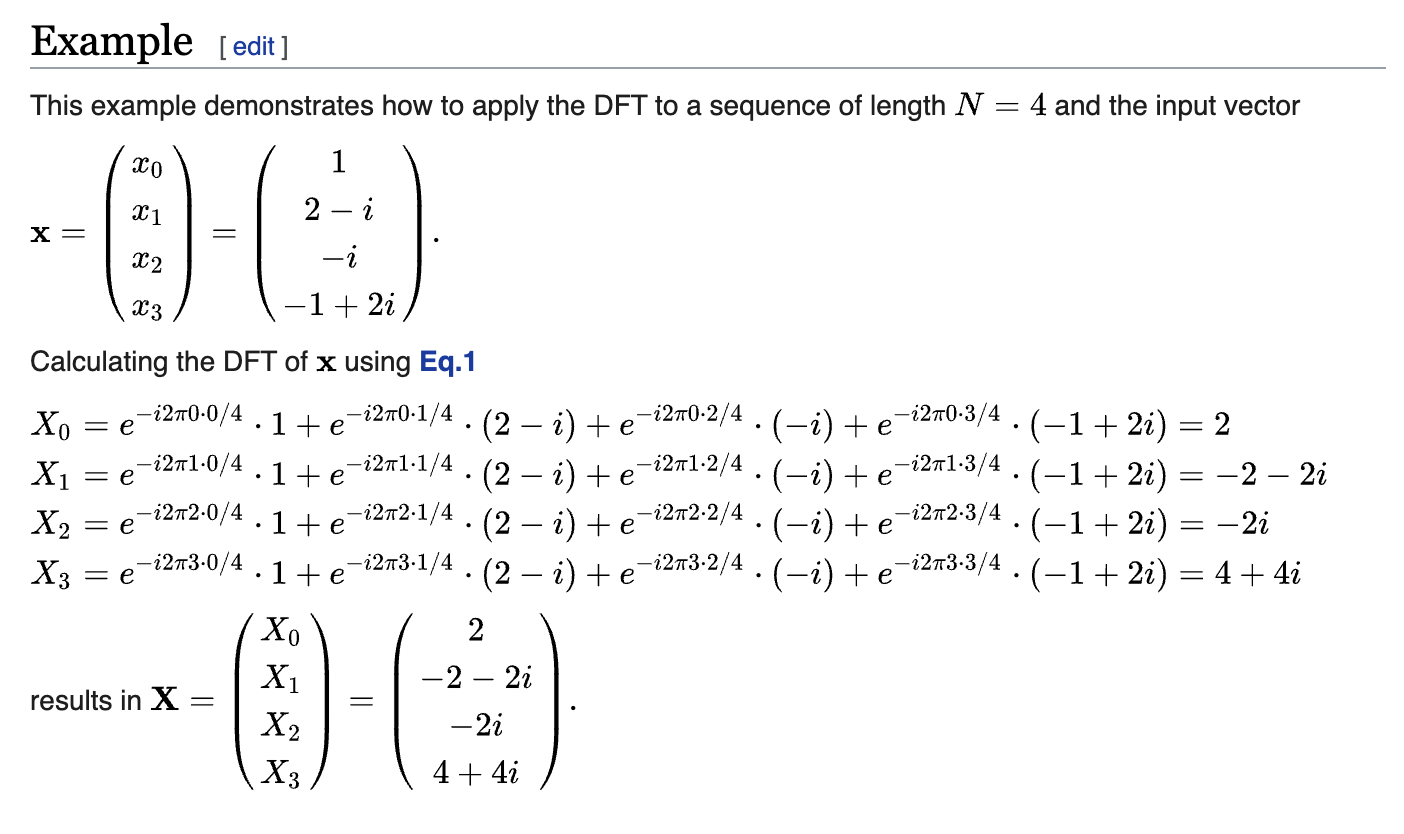
<figcaption aria-hidden="true">그림2: 위키에서 긁어온
예제이미지</figcaption>
</figure>

예제를 풀기위해서 우선 아래와 같은 벡터를 선언하다.

[1] discrete Fourier transform

[2] $X_k = \sum_{n=0}^{N-1}x_n\cdot e^{-i\frac{2\pi}{N}kn}$

In [36]:
x = [1, 2-im, -im, -1+2im]

(풀이1)

$4\times 4$의 크기를 가지는 DFT행렬을 선언한다.

(step1) 아래의 매트릭스 생성

In [38]:
_DFT = reshape([i*j for i in 0:3 for j in 0:3], (4,4))
_DFT

(step2) `_DFT`의 각 원소에 함수 $f: x \to \exp(-i\frac{2\pi}{4}x)$를
취함

In [39]:
f = x -> exp(-im * (2π/4) * x)
DFT = _DFT .|> f

이제 ${\bf X}$를 구하면 아래와 같다.

In [40]:
DFT * x

위키의 답이 잘 나옴

(풀이2)

참고로 아래와 같이 패키지를 이용하여 구할 수도 있다.

In [41]:
fft(x)

## Inverse DFT

앞으로는 ${\bf DFT}$를 아래와 같이 정의하자.

$${\bf DFT} = \frac{1}{\sqrt{N}}\begin{bmatrix} 
1 & 1 & 1 & \dots & 1 \\
1 & e^{-i \frac{2\pi}{N}\cdot 1} & e^{-i \frac{2\pi}{N}\cdot 2} & \dots & e^{-i \frac{2\pi}{N}\cdot (N-1)}\\
1 & e^{-i \frac{2\pi}{N}\cdot 2} & e^{-i \frac{2\pi}{N}\cdot 4} & \dots & e^{-i \frac{2\pi}{N}\cdot 2(N-1)}\\
\dots & \dots & \dots & \dots & \dots \\ 
1 & e^{-i \frac{2\pi}{N}\cdot (N-1)} & e^{-i \frac{2\pi}{N}\cdot 2(N-1)} & \dots & e^{-i \frac{2\pi}{N}\cdot (N-1)^2}
    \end{bmatrix} \tag{8.6}$$

${\bf DFT}$행렬에는 몇 가지 특징이 있다.

**<font color='green'>특징1:</font>** 유니터리행렬이다[1]. 즉
${\bf DFT}^\ast \cdot {\bf DFT} = {\bf DFT}^\ast \cdot{\bf DFT} = {\bf I}$
이다.

[1] 켤레 전치가 역행렬과 같은 복소수 정사각 행렬.

In [42]:
_DFT = reshape([i*j for i in 0:3 for j in 0:3], (4,4))
f = x -> exp(-im * (2π/4) * x)
DFT = _DFT .|> f
DFT # 아까의 예제의 DFT!

In [43]:
DFT = (1/√4)*DFT # 새로운 DFT의 정의 
DFT'DFT .|> round # 유니터리행렬임을 확인!

**<font color='green'>특징2:</font>** ${\bf DFT}$는 대칭행렬이다. 따라서
이 행렬의 켤레전치는 DFT의 각 원소에서 단순히 $i=\sqrt{-1}$ 대신에 $-i$
를 넣은 것과 같다.

특징1-2를 조합하면 아래와 같이 ${\bf DFT}$에서 $i$ 대신에 $-i$를 넣은
행렬이 변환 DFT를 취소시킬 수 있음을 이해할 수 있다. [1]

$$\frac{1}{\sqrt{N}}\begin{bmatrix} 
1 & 1 & 1 & \dots & 1 \\
1 & e^{i \frac{2\pi}{N}\cdot 1} & e^{i \frac{2\pi}{N}\cdot 2} & \dots & e^{i \frac{2\pi}{N}\cdot (N-1)}\\
1 & e^{i \frac{2\pi}{N}\cdot 2} & e^{i \frac{2\pi}{N}\cdot 4} & \dots & e^{i \frac{2\pi}{N}\cdot 2(N-1)}\\
\dots & \dots & \dots & \dots & \dots \\ 
1 & e^{i \frac{2\pi}{N}\cdot (N-1)} & e^{i \frac{2\pi}{N}\cdot 2(N-1)} & \dots & e^{i \frac{2\pi}{N}\cdot (N-1)^2}
    \end{bmatrix}$$

행렬 ${\bf DFT}$를 discrete Fourier transform으로 생각했듯이 위의 행렬을
inverse discrete Fourier transform으로 해석할 수 있다.

## DFT의 또 다른 정의

이번에는 ${\bf DFT}$에 대한 다른 정의를 생각해보자. 우선 아래와 같은
행렬 ${\bf B}$를 고려하자.

[1] 아래의 행렬은 ${\bf DFT}^\ast$ 혹은 ${\bf DFT}$의 conjugate matrix
혹은 ${\bf DFT}^{-1}$로 생각할 수 있음

In [44]:
B= [0 0 0 1 
    1 0 0 0 
    0 1 0 0
    0 0 1 0]

이것은 길이가 4인 임의의 column vector를 아래로 한칸씩 이동시키는
매트릭스이다.

In [45]:
x = [1, 2-im, -im, -1+2im]

In [46]:
B*x # 아래로 한칸이동 

In [47]:
B^2*x # 아래로 두칸이동, B^2*x = B*(Bx) 이므로 

한편 이 매트릭스 ${\bf B}$는 아래와 같이 고유분해가 가능하다.

$$ {\bf B} = {\bf \Psi} {\bf \Lambda} {\bf \Psi}^\ast$$

-   ${\bf \Psi}$: make
    $\frac{1}{\sqrt{N}}[e^{\sqrt{-1} \frac{2\pi}{N} ij}~\text{ for }~ i=0,1,2,\dots,N-1~\text{ for }~j=0,1,2,\dots,N-1]$
    and apply `reshape` function with $(N,N)$.
-   ${\bf \Lambda}$: make
    $[e^{-\sqrt{-1}\frac{2\pi}{N}i}~\text{ for }~ i=0,1,2\dots,N-1]$ and
    apply `Diagonal` function.

In [48]:
N = 4 
λ = [exp(-im * (2π/N) *i) for i in 0:(N-1)]
Λ = Diagonal(λ)
_Ψ = 1/√N *[exp(im * (2π/N) * i*j) for i in 0:(N-1) for j in 0:(N-1)]
Ψ = reshape(_Ψ, (N,N))
B ≈ Ψ * Λ * Ψ'

In [55]:
Ψ'

그런데 위에서 정의된 ${\bf \Psi}^\ast$는 우리가 그전에 정의하였던
${\bf DFT}$의 행렬과 같다.

In [53]:
_DFT = reshape([i*j for i in 0:3 for j in 0:3], (4,4))
DFT = _DFT .|> (x -> exp(-im * (2π/4) * x)) 
DFT = DFT * 1/√N

In [56]:
Ψ' == DFT 

> **Note**
>
> 결국 요약하면 길이가 $N$인 신호의 ${\bf DFT}$행렬은 아래의 과정으로
> 구할 수 있음을 알 수 있다.
>
> 1.  Forward operator ${\bf A}$를 정의한다.
> 2.  ${\bf A}$의 고유벡터행렬 ${\bf \Psi}$을 구한다. [1]
> 3.  ${\bf \Psi}$의 conjugate transpose matrix ${\bf \Psi}^\ast$ 를
>     구한다. 이것이 ${\bf DFT}$ matrix 이다. [2]

## Spectral component and Frequencies

${\bf A}$의 고유벡터 ${\bf \Psi}$의 각 column을 spectral component라고
부른다.

[1] 고유벡터행렬은 고유값 $e^{-\sqrt{-1}\frac{2\pi}{N}i}$에 의하여
정렬되어 있어야 함.

[2] 사실 이미 대칭행렬이므로 conjugate matrix만 구하면 된다.

In [57]:
ψ₁ = Ψ[:,1] # ψ₁ is first spectral component 
ψ₂ = Ψ[:,2] # ψ₂ is seconde spectral component 
ψ₃ = Ψ[:,3] # ψ₃ is third spectral component 
ψ₄ = Ψ[:,4] # ψ₄ is last spectral component

그리고 아래와 같은 수열을 $\Omega_{k}=\frac{k}{N}$을 frequency 라고
부른다.

In [58]:
N=4 
Ω = [k/N for k in 0:(N-1)]
Ω

# Ref

-   <https://miruetoto.github.io/yechan3/posts/2_Studies/CGSP/2022-12-24-Chap-8.3.html>

Djuric, Petar, and Cédric Richard. 2018. *Cooperative and Graph Signal
Processing: Principles and Applications*. Academic Press.